In [130]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer 
  
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Notice that these vectorizers are from `sklearn` and not `nltk`!
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /Users/jayiraj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/jayiraj/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jayiraj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [131]:
df= pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [132]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [133]:
# Rename the columns
df = df.rename(columns={
    'emotion_in_tweet_is_directed_at': 'products',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotions'
})

df.head()

,tweet_text,products,emotions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [134]:
df['emotions'] = df['emotions'].replace('No emotion toward brand or product', 'Neutral')
df['emotions'] = df['emotions'].replace('Positive emotion', 'Positive')
df['emotions'] = df['emotions'].replace('Negative emotion', 'Negative')

In [135]:
df = df[df['emotions'].isin(['Neutral', 'Negative', 'Positive'])]

In [136]:
df['emotions'].value_counts()

Neutral     5389
Positive    2978
Negative     570
Name: emotions, dtype: int64

In [137]:
#Map emotions to target values
#label_encoder = LabelEncoder()

# Fitting the encoder to the 'emotions' column and transforming it
#df['target'] = label_encoder.fit_transform(df['emotions'])

# Checking the first few rows to see the result
#df.head()


In [138]:
df['emotions'].value_counts()

Neutral     5389
Positive    2978
Negative     570
Name: emotions, dtype: int64

In [139]:
df.isna().sum()

tweet_text       1
products      5655
emotions         0
dtype: int64

In [140]:
df = df.dropna(subset=['tweet_text'])

In [141]:
df.isna().sum()

tweet_text       0
products      5654
emotions         0
dtype: int64

In [142]:
# Bring in stopwords

sw = stopwords.words('english')

In [143]:
# Add custom words to the stopword list
custom_stopwords = ['sxsw', 'mention','link','rt', 'for','quot']

# Extend the NLTK stopword list with custom stopwords
sw.extend(custom_stopwords)

In [144]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [145]:
lemmatizer = WordNetLemmatizer() 

In [146]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: column from database
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokens = regex_token.tokenize(doc)
    lowered_t = [word.lower() for word in tokens]
    no_sw_t = [word for word in lowered_t if word not in sw]
    # print(doc)
    tokens_tagged = pos_tag(no_sw_t)
    pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged] 
    tokens_lemm = [lemmatizer.lemmatize(word[0], word[1]) for word in pos_tokens]
    return ' '.join(tokens_lemm)

In [165]:
# Create a new column in your DataFrame for the preprocessed text
df['preprocessed_text'] = df['tweet_text'].apply(lambda x: doc_preparer(x))

# Now you can perform EDA on 'preprocessed_text'
# For example, token frequency analysis
from collections import Counter
all_words = ' '.join(df['preprocessed_text']).split()
word_freq = Counter(all_words)


# Word Frequency By Target

In [118]:
positive_df = df[df['emotions']=='Positive']
neutral_df = df[df['emotions']== 'Neutral']
negative_df = df[df['emotions']=='Negative']

In [119]:
neutral_df

,tweet_text,products,emotions,preprocessed_text
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,Neutral,teachntech new ipad apps speechtherapy communi...
16,Holler Gram for iPad on the iTunes App Store -...,NaN,Neutral,holler gram ipad itunes app store http co kfn ...
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,Neutral,attn frineds register gdgtlive see cobra irada...
33,Anyone at #sxsw want to sell their old iPad?,NaN,Neutral,anyone want sell old ipad
34,Anyone at #SXSW who bought the new iPad want ...,NaN,Neutral,anyone buy new ipad want sell old ipad
...,...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,Neutral,yup third app yet android suggestion cc
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,Neutral,wave buzz interrupt regularly schedule geek pr...
9090,"Google's Zeiger, a physician never reported po...",NaN,Neutral,google zeiger physician never report potential...
9091,Some Verizon iPhone customers complained their...,NaN,Neutral,verizon iphone customer complain time fell bac...


In [121]:
positive_words = ' '.join(positive_df['preprocessed_text']).split()

# Compute the frequency distribution
pos_freq_dist = FreqDist(positive_words)

# Display the most common words
print(freq_dist.most_common(50))

[('ipad', 2961), ('google', 2621), ('apple', 2309), ('iphone', 1560), ('store', 1508), ('new', 1086), ('austin', 959), ('amp', 834), ('app', 821), ('launch', 817), ('get', 693), ('circle', 673), ('social', 658), ('pop', 601), ('android', 594), ('today', 576), ('open', 520), ('go', 477), ('network', 473), ('line', 452), ('via', 428), ('party', 401), ('call', 395), ('free', 390), ('mobile', 357), ('come', 347), ('sxswi', 340), ('win', 313), ('one', 313), ('time', 309), ('see', 308), ('check', 305), ('like', 303), ('major', 303), ('use', 291), ('day', 288), ('make', 285), ('map', 273), ('w', 269), ('u', 266), ('temporary', 264), ('need', 240), ('possibly', 240), ('look', 233), ('great', 226), ('people', 226), ('design', 225), ('downtown', 225), ('apps', 223), ('mayer', 219)]


In [122]:
neutral_words = ' '.join(neutral_df['preprocessed_text']).split()

# Compute the frequency distribution
neut_freq_dist = FreqDist(neutral_words)

# Display the most common words
print(neut_freq_dist.most_common(50))

[('google', 1733), ('ipad', 1501), ('apple', 1249), ('store', 899), ('iphone', 843), ('new', 680), ('austin', 634), ('amp', 601), ('launch', 593), ('circle', 512), ('social', 503), ('today', 441), ('pop', 366), ('network', 362), ('app', 360), ('android', 359), ('get', 359), ('open', 329), ('call', 304), ('via', 282), ('line', 282), ('free', 262), ('go', 261), ('mobile', 242), ('party', 241), ('sxswi', 231), ('major', 230), ('check', 197), ('possibly', 191), ('come', 181), ('make', 178), ('see', 177), ('u', 175), ('temporary', 170), ('win', 155), ('w', 149), ('time', 145), ('use', 143), ('map', 143), ('mayer', 140), ('like', 140), ('design', 140), ('one', 139), ('know', 139), ('day', 138), ('need', 138), ('downtown', 136), ('say', 134), ('popup', 131), ('talk', 129)]


In [123]:
negative_words = ' '.join(negative_df['preprocessed_text']).split()

# Compute the frequency distribution
neg_freq_dist = FreqDist(negative_words)

# Display the most common words
print(neg_freq_dist.most_common(50))

[('ipad', 211), ('iphone', 166), ('google', 152), ('apple', 123), ('app', 60), ('store', 47), ('new', 45), ('like', 43), ('get', 42), ('circle', 37), ('need', 35), ('go', 32), ('social', 31), ('design', 30), ('apps', 30), ('people', 29), ('launch', 29), ('austin', 28), ('think', 28), ('android', 24), ('use', 24), ('take', 24), ('look', 24), ('line', 23), ('one', 23), ('time', 23), ('come', 22), ('amp', 22), ('day', 22), ('say', 21), ('call', 21), ('today', 21), ('fail', 20), ('would', 19), ('see', 18), ('news', 18), ('give', 18), ('pop', 18), ('good', 18), ('network', 18), ('long', 18), ('phone', 18), ('make', 18), ('year', 17), ('headache', 17), ('battery', 17), ('product', 17), ('talk', 17), ('user', 16), ('wait', 16)]


In [125]:
pos_documents = positive_df['preprocessed_text']
pos_tfidf_vectorizer = TfidfVectorizer()
pos_tfidf_matrix = pos_tfidf_vectorizer.fit_transform(pos_documents)

pos_feature_names = pos_tfidf_vectorizer.get_feature_names()
pos_tfidf_scores = pos_tfidf_matrix.sum(axis=0).A1

pos_tfidf_df = pd.DataFrame({'Term': pos_feature_names, 'Positive TF-IDF Score': pos_tfidf_scores})
pos_tfidf_df = pos_tfidf_df.sort_values(by='Positive TF-IDF Score', ascending=False)

print(pos_tfidf_df.head(50)) 

           Term  Positive TF-IDF Score
1884       ipad             154.291213
165       apple             143.620946
3429      store             104.645227
1514     google             104.193839
1887     iphone              86.639628
158         app              73.683742
2434        new              68.241995
230      austin              64.453059
1469        get              60.077230
2738        pop              53.166658
2526       open              48.685327
2035     launch              47.332573
128     android              45.319248
1496         go              43.185552
4015        win              43.103401
122         amp              41.590144
2092       line              38.933030
3907        via              37.617989
2608      party              36.932484
2521        one              36.432634
678        come              35.729378
613      circle              33.151687
3681       time              32.838021
759        cool              32.399849
1546      great          

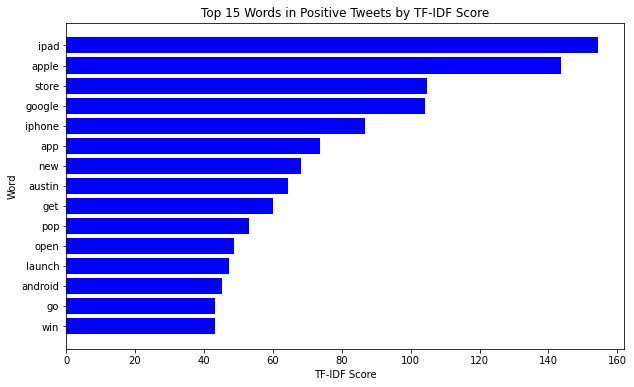

In [164]:

# Get the top 15 terms and scores
p_top_terms = pos_tfidf_df.head(15)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(p_top_terms['Term'], p_top_terms['Positive TF-IDF Score'], color='blue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Top 15 Words in Positive Tweets by TF-IDF Score')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.show()

In [129]:
neut_documents = neutral_df['preprocessed_text']
neut_tfidf_vectorizer = TfidfVectorizer()
neut_tfidf_matrix = neut_tfidf_vectorizer.fit_transform(neut_documents)

neut_feature_names = neut_tfidf_vectorizer.get_feature_names()
neut_tfidf_scores = neut_tfidf_matrix.sum(axis=0).A1

neut_tfidf_df = pd.DataFrame({'Term': neut_feature_names, 'Neutral TF-IDF Score': neut_tfidf_scores})
neut_tfidf_df = neut_tfidf_df.sort_values(by='Neutral TF-IDF Score', ascending=False)

print(neut_tfidf_df.head(50)) 

           Term  Neutral TF-IDF Score
2181     google            242.853670
232       apple            222.468168
2667       ipad            220.671304
4872      store            188.764133
2886     launch            143.658317
3440        new            141.111399
2671     iphone            136.982466
338      austin            136.195986
900      circle            132.715950
4706     social            124.457316
5218      today            108.018917
174         amp            107.414224
3897        pop            104.710746
3435    network            104.254628
3596       open             94.784958
738        call             87.299676
227         app             78.623975
2126        get             78.114264
183     android             77.569490
2971       line             77.091749
5519        via             75.562377
3093      major             73.674919
3922   possibly             64.446633
2162         go             62.442548
2002       free             61.823076
3296     mob

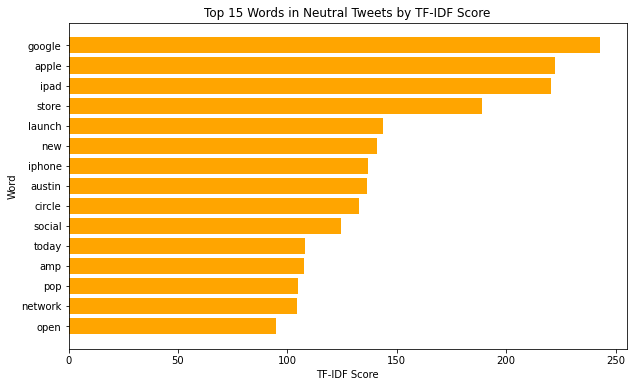

In [163]:
import matplotlib.pyplot as plt

# Get the top 15 terms and scores
neutral_top_terms = neut_tfidf_df.head(15)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(neutral_top_terms['Term'], neutral_top_terms['Neutral TF-IDF Score'], color='orange')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Top 15 Words in Neutral Tweets by TF-IDF Score')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.show()

In [128]:
neg_documents = negative_df['preprocessed_text']
neg_tfidf_vectorizer = TfidfVectorizer()
neg_tfidf_matrix = neg_tfidf_vectorizer.fit_transform(neg_documents)

neg_feature_names = neg_tfidf_vectorizer.get_feature_names()
neg_tfidf_scores = neg_tfidf_matrix.sum(axis=0).A1

neg_tfidf_df = pd.DataFrame({'Term': neg_feature_names, 'Negative TF-IDF Score': neg_tfidf_scores})
neg_tfidf_df = neg_tfidf_df.sort_values(by='Negative TF-IDF Score', ascending=False)

print(neg_tfidf_df.head(50)) 

          Term  Negative TF-IDF Score
803       ipad              29.184340
807     iphone              23.980497
660     google              22.291693
76       apple              20.509869
72         app              13.120671
1456     store              10.716217
1017       new               9.622512
242     circle               9.467943
881       like               9.466544
642        get               9.087582
388     design               8.697925
1407    social               8.205424
1008      need               7.702755
80        apps               7.700989
651         go               7.677360
861     launch               7.492156
1111    people               7.152733
1533     think               7.094180
96      austin               6.855483
54     android               6.524456
901       look               6.506600
885       line               6.425563
706   headache               6.172291
1622       use               6.167538
1502      take               5.966912
1545      ti

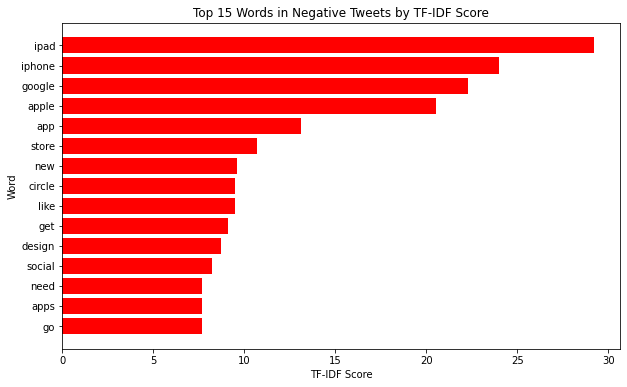

In [161]:

# Get the top 15 terms and scores
n_top_terms = neg_tfidf_df.head(15)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(n_top_terms['Term'], n_top_terms['Negative TF-IDF Score'], color='red')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Top 15 Words in Negative Tweets by TF-IDF Score')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.show()

In [62]:
all_words = ' '.join(df['preprocessed_text']).split()

# Compute the frequency distribution
freq_dist = FreqDist(all_words)

# Display the most common words
print(freq_dist.most_common(50))

[('ipad', 2961), ('google', 2621), ('apple', 2309), ('iphone', 1560), ('store', 1508), ('new', 1086), ('austin', 959), ('amp', 834), ('app', 821), ('launch', 817), ('get', 693), ('circle', 673), ('social', 658), ('pop', 601), ('android', 594), ('today', 576), ('open', 520), ('go', 477), ('network', 473), ('line', 452), ('via', 428), ('party', 401), ('call', 395), ('free', 390), ('mobile', 357), ('come', 347), ('sxswi', 340), ('win', 313), ('one', 313), ('time', 309), ('see', 308), ('check', 305), ('like', 303), ('major', 303), ('use', 291), ('day', 288), ('make', 285), ('map', 273), ('w', 269), ('u', 266), ('temporary', 264), ('need', 240), ('possibly', 240), ('look', 233), ('great', 226), ('people', 226), ('design', 225), ('downtown', 225), ('apps', 223), ('mayer', 219)]


In [96]:
df

,tweet_text,products,emotions,preprocessed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,wesley g iphone hr tweet rise austin dead need...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,jessedee know fludapp awesome ipad iphone app ...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,swonderlin wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,sxtxstate great stuff fri marissa mayer google...
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive,ipad everywhere
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,Neutral,wave buzz interrupt regularly schedule geek pr...
9090,"Google's Zeiger, a physician never reported po...",NaN,Neutral,google zeiger physician never report potential...
9091,Some Verizon iPhone customers complained their...,NaN,Neutral,verizon iphone customer complain time fell bac...


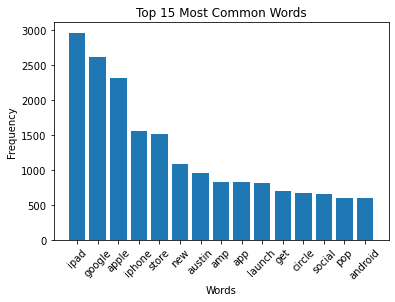

In [98]:
import matplotlib.pyplot as plt

# Get the most common words and their counts
common_words = freq_dist.most_common(15)
words, counts = zip(*common_words)

# Create a bar chart
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Common Words')
plt.xticks(rotation=45)
plt.show()

# Splitting our Data

In [64]:
X = df['tweet_text'] 
y = df['emotions'] 

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Creating Pipelines

In [66]:

#Multinomial Naive Bayes Pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=doc_preparer)),
    ('nb', MultinomialNB())
])

In [67]:
#Random Forest Pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=doc_preparer)),
    ('rf', RandomForestClassifier(random_state = 42, class_weight='balanced'))
])

# Grid Search Set Up

In [68]:
nb_param_grid = {
    'tfidf__max_df': [0.75],
    'tfidf__min_df': [.01,.05,.1],
    'tfidf__ngram_range': [(1, 2)],
}

In [111]:
rf_param_grid = {
    'tfidf__max_df': [.6, .62],
    'tfidf__min_df': [1],
    'tfidf__ngram_range': [(1, 1)],
    'rf__n_estimators': [150], 
    'rf__max_depth': [None, 30],
 'rf__min_samples_split':[4],
   'rf__min_samples_leaf':[1],
'rf__max_features': [60, 80]}

# Naive Bayes Grid Search

In [85]:
nb_grid_search = GridSearchCV(nb_pipeline, nb_param_grid, cv=3, n_jobs=1, verbose=2)
nb_grid_search.fit(X_train, y_train) 

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   2.9s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2), total=   2.9s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2), total=   2.9s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2), total=   2.9s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.1, tfid

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   25.7s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function doc_preparer at 0x7fdaa9ec6ee0>)),
                                       ('nb', MultinomialNB())]),
             n_jobs=1,
             param_grid={'tfidf__max_df': [0.75],
                         'tfidf__min_df': [0.01, 0.05, 0.1],
                         'tfidf__ngram_range': [(1, 2)]},
             verbose=2)

# Random Forest Grid Search

In [108]:
# Grid search with RandomForestClassifier pipeline
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, n_jobs=1, verbose=2)
rf_grid_search.fit(X_train, y_train) 

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] rf__max_depth=None, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rf__max_depth=None, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=None, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV]  rf__max_depth=None, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__max_depth=None, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__max_depth=None, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__max_depth=None, rf__max_features=80, rf__min_s

[CV]  rf__max_depth=None, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=None, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=None, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=None, rf__max_features=80, rf__min_s

[CV]  rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=None, rf__max_features=100, rf_

[CV]  rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=150, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=150, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=150, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=None, rf__max_features=100, rf_

[CV]  rf__max_depth=None, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=None, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=None, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=None, rf__max_features=110, rf_

[CV]  rf__max_depth=60, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=60, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=60, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=60, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=60, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=60, rf__max_features=80, rf__min_samples_leaf=

[CV]  rf__max_depth=60, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.6s
[CV] rf__max_depth=60, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=60, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=60, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=60, rf__max_features=80, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=60, rf__max_features=80, rf__min_samples_leaf=

[CV]  rf__max_depth=60, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=60, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=60, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=60, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=60, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=60, rf__max_features=100, rf__min_samples

[CV]  rf__max_depth=60, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=60, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=60, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=60, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=60, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=140, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=60, rf__max_features=110, rf__min_samples

[CV]  rf__max_depth=60, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=60, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=60, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=60, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=60, rf__max_features=110, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=140, tfidf__max_df=0.7, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=60, rf__max_features=110, rf__min_samples

[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed: 15.6min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function doc_preparer at 0x7fdaa9ec6ee0>)),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=1,
             param_grid={'rf__max_depth': [None, 60],
                         'rf__max_features': [80, 100, 110],
                         'rf__min_samples_leaf': [1],
                         'rf__min_samples_split': [4, 8],
                         'rf__n_estimators': [140, 150],
                         'tfidf__max_df': [0.6, 0.7, 0.9], 'tfidf__min_df': [1],
                         'tfidf__ngram_range': [(1, 1)]},
             verbose=2)

# Model Evaluation

In [87]:
# Evaluation for Naive Bayes


nb_best_model = nb_grid_search.best_estimator_
print("Best Parameters for Naive Bayes:", nb_grid_search.best_params_)
print("Grid Search Best Score:", nb_grid_search.best_score_)

Best Parameters for Naive Bayes: {'tfidf__max_df': 0.75, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 2)}
Grid Search Best Score: 0.6333242664037727


In [88]:
nb_best_model.score(X_train, y_train)

0.6484331281477337

In [109]:
#Evaluation for Random Forest
rf_best_model = rf_grid_search.best_estimator_
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Grid Search Best Score:", rf_grid_search.best_score_)

Best Parameters for Random Forest: {'rf__max_depth': None, 'rf__max_features': 80, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 4, 'rf__n_estimators': 150, 'tfidf__max_df': 0.6, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Grid Search Best Score: 0.6723556951768749


In [110]:
rf_best_model.score(X_train, y_train)

0.9570509233351987

# Confusion Matrix

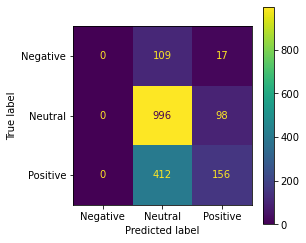

In [91]:
y_pred_nb = nb_best_model.predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred_nb)
# Plot the Confusion Matrix with a smaller size
fig, ax = plt.subplots(figsize=(4, 4))  
ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels= nb_best_model.classes_).plot(ax=ax)

# Show the plot
plt.show()

In [112]:
y_pred_rf = rf_best_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_accuracy

0.6817673378076062

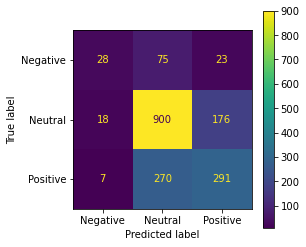

In [113]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Plot the Confusion Matrix with a smaller size
fig, ax = plt.subplots(figsize=(4, 4))  
ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels= rf_best_model.classes_).plot(ax=ax)

# Show the plot
plt.show()

## Features importances

In [73]:
rf_tfidf_vectorizer = rf_best_model.named_steps['tfidf']
rf_tfidf_feature_names = rf_tfidf_vectorizer.get_feature_names()
rf_tfidf_feature_importances = rf_tfidf_vectorizer.idf_

In [74]:
rf_model = rf_best_model.named_steps['rf']
rf_feature_importances = rf_model.feature_importances_

In [114]:
feature_importance_df = pd.DataFrame({'Feature': rf_tfidf_feature_names, 'Importance': rf_feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(50)) 

       Feature  Importance
3155      ipad    0.017192
281      apple    0.013287
2556    google    0.011467
3159    iphone    0.011032
5781     store    0.010348
274        app    0.008106
403     austin    0.006874
210        amp    0.006679
4055       new    0.006678
2493       get    0.005514
3416    launch    0.005185
4597       pop    0.005119
1277      cool    0.005011
3506      like    0.004974
2117      fail    0.004913
4439    people    0.004735
2602     great    0.004675
1042    circle    0.004643
2750  headache    0.004611
3517      line    0.004436
223    android    0.004320
4239      open    0.004229
5842      suck    0.004102
6203     today    0.004044
2349      free    0.003936
5576    social    0.003931
1559    design    0.003799
4379     party    0.003750
451    awesome    0.003731
4029      need    0.003714
2531        go    0.003671
4224       one    0.003640
6132     think    0.003545
6757       win    0.003491
3576      look    0.003475
3596      love    0.003455
3

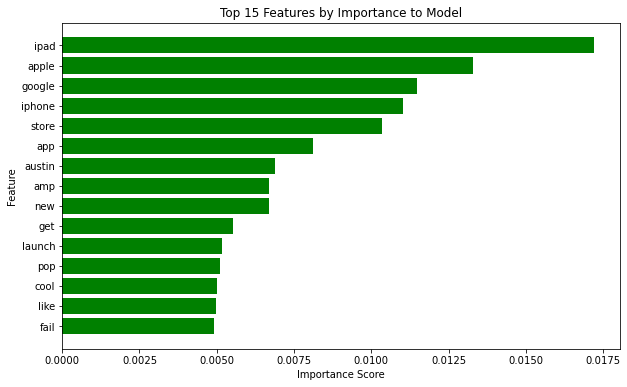

In [160]:
# Get the top 15 features and their importance scores
top_features = feature_importance_df.head(15)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='green')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 15 Features by Importance to Model')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest importance at the top
plt.show()

In [115]:
documents = df['preprocessed_text']
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

feature_names = tfidf_vectorizer.get_feature_names()
tfidf_scores = tfidf_matrix.sum(axis=0).A1

tfidf_df = pd.DataFrame({'Term': feature_names, 'TF-IDF Score': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='TF-IDF Score', ascending=False)

print(tfidf_df.head(50)) 

           Term  TF-IDF Score
3482       ipad    393.706915
310       apple    376.081488
2822     google    359.336209
6395      store    299.138856
3489     iphone    239.375512
4510        new    213.162008
441      austin    204.370285
3787     launch    195.979945
1157     circle    174.148013
6181     social    162.560269
300         app    161.070850
5116        pop    160.827025
228         amp    151.833258
4718       open    144.916383
2748        get    143.244584
6863      today    141.818031
4503    network    134.492131
242     android    125.641611
3896       line    120.142966
7258        via    114.108774
953        call    112.411049
2794         go    109.715918
4059      major     95.048426
4874      party     94.983691
2586       free     91.938646
6706  temporary     90.543664
4321     mobile     90.078535
6568      sxswi     84.255925
7479        win     83.082897
1268       come     83.020958
1093      check     81.569801
5147   possibly     80.422134
1935   dow

# Model Evaluation on the Test Set